In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as st
import matplotlib.pylab as plt

import theano

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


https://discourse.pymc.io/t/hierarchical-linear-regression-model-why-is-it-not-converging/950/3

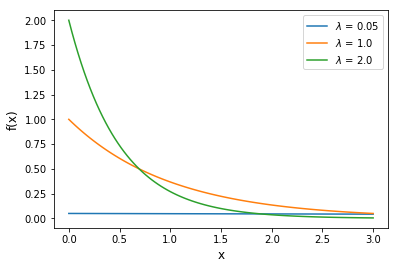

In [2]:
x = np.linspace(0, 3, 100)
for lam in [1/20, 1., 2.]:
    pdf = st.expon.pdf(x, scale=1.0/lam)
    plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [3]:
N = 30
beta_0 = [3, 3.2, 2.4, 4.1]
beta_1 = [11, 10, 9.1, 14.1]
idx = np.repeat(range(4),N)
x = np.array([]) ; y = np.array([])
for b_0,b_1 in zip(beta_0,beta_1): 
    x_new = st.uniform(0,20).rvs(N)
    x = np.append(x, x_new)
    eps = st.norm(0,10).rvs(N)
    y = np.append(y,b_0 + b_1*x_new + eps)
x = np.append(x,10) ; y = np.append(y,3+11*10)
idx = np.append(idx,4)

In [4]:
with pm.Model() as hierarch:
    mu_b_0 = pm.Normal("mu_b_0", mu=0, sd=100)
    sd_b_0 = pm.HalfCauchy("sd_b_0", 5)
    mu_b_1 = pm.Normal("mu_b_1", mu=0, sd=100)
    sd_b_1 = pm.HalfCauchy("sd_b_1", 5)
    beta0_ = pm.Normal("beta0_", mu=0, sd=1, shape=5)
    beta1_ = pm.Normal("beta1_", mu=0, sd=1, shape=5)
    beta_0 = pm.Deterministic('beta_0', beta0_*sd_b_0+mu_b_0)
    beta_1 = pm.Deterministic('beta_1', beta1_*sd_b_1+mu_b_1)
    nu = pm.Exponential("nu", 2)
    eps = pm.HalfCauchy("eps", 5)
    pred = pm.StudentT(
        "pred", mu=beta_0[idx] + beta_1[idx] * x, sd=eps, nu=nu+1, observed=y)
    trace_hier = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, nu_log__, beta1_, beta0_, sd_b_1_log__, mu_b_1, sd_b_0_log__, mu_b_0]
100%|██████████| 3000/3000 [00:43<00:00, 69.10it/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6976818889679055, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


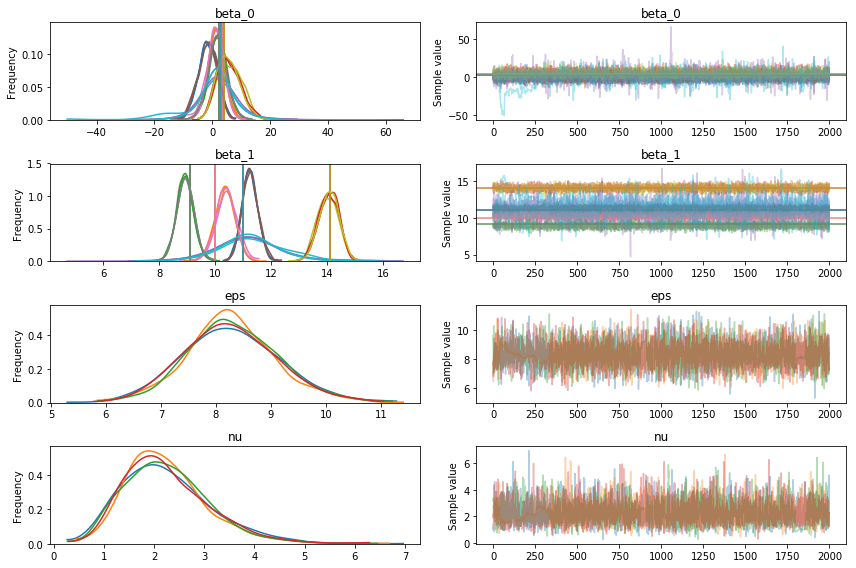

In [5]:
pm.traceplot(trace_hier, varnames=['beta_0', 'beta_1', 'eps', 'nu'],
            lines={'beta_0':[3, 3.2, 2.4, 4.1, 3],
                   'beta_1':[11, 10, 9.1, 14.1, 11]});

https://discourse.pymc.io/t/how-can-we-build-a-mixture-of-mixtures/910/18

In [1]:
import pymc3 as pm, theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt

# simulated data :  a mix of 2 lognormal
data = np.concatenate( (
    np.random.lognormal(mean=3,sigma=0.5,size=1000),
    np.random.lognormal(mean=5,sigma=0.5,size=1000)) )

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
nbr = 5
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.array([0.0000001]*nbr)) # weight vector for the mixture
    mu = pm.Exponential('mu', lam=1, shape=nbr)
    sd = pm.Exponential('sd', lam=1, shape=nbr)
    components = pm.Lognormal.dist(mu=mu, sd=sd, shape=nbr) 
    obs = pm.Mixture('y', w, components, observed=data)
    tr = pm.sample()

In [3]:
with pm.Model() as model:
    # "continuous" part : lognormal mixture
    ln_nbr = 5
    mu = pm.Exponential('mu', lam=1, shape=ln_nbr)
    sd = pm.HalfNormal('sd', sd=1, shape=ln_nbr)
    ln_components = pm.Lognormal.dist(mu=mu,sd=sd,shape=ln_nbr)
    ln_w = pm.Dirichlet('ln_w',a=np.array([0.0000001]*ln_nbr))
    ln_mix = pm.Mixture.dist(w=ln_w,comp_dists=ln_components, shape=1)

ln_mix.logp(np.asarray([10.]))

Elemwise{switch,no_inplace}.0

In [6]:
ln_mix.logp(np.random.lognormal(size=100))

Elemwise{switch,no_inplace}.0

In [11]:
mu_g = np.arange(5,50,5)
ln_mix.logp(np.asarray([mu_g]).flatten()).tag.test_value

array([[ -2.96199652],
       [ -5.03014159],
       [ -6.58978369],
       [ -7.85298049],
       [ -8.92231757],
       [ -9.85409017],
       [-10.68262926],
       [-11.43051321],
       [-12.11344185]])

In [3]:
with pm.Model() as model:
    # "continuous" part : lognormal mixture
    ln_nbr = 5
    mu = pm.Exponential('mu', lam=1, shape=ln_nbr)
    sd = pm.HalfNormal('sd', sd=1, shape=ln_nbr)
    ln_components = pm.Lognormal.dist(mu=mu,sd=sd,shape=ln_nbr)
    ln_w = pm.Dirichlet('ln_w',a=np.array([0.0000001]*ln_nbr))
    ln_mix = pm.Mixture.dist(w=ln_w,comp_dists=ln_components, shape=1)

ln_mix.logp(np.asarray([10.]))

Elemwise{switch,no_inplace}.0

https://discourse.pymc.io/t/multidimensional-gaussian-process/907/29

In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


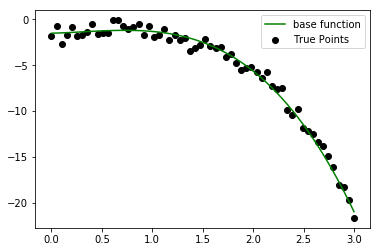

In [2]:
#Define a function
def fxn(x,params):
    return np.polyval(params,x)

#Initialize the parameters to the base value
np.random.seed(123)
params = np.random.normal(loc=0.,scale=1,size=4)

#Create the base function
m = 60
x = np.linspace(0,3,m)
y = (fxn(x,params).flatten()+np.random.normal(loc=0,scale=0.5,size=m))
y_true = fxn(x,params)
     
plt.scatter(x,y,marker='o',color='k',label='True Points')
plt.plot(x,y_true,color='g',label='base function')
plt.legend()
plt.show()

In [3]:
#Create a sample of the parameters distributed about the true values
n = 30
a = np.random.normal(loc=params[0],scale=0.1*abs(params[0]),size=n)
b = np.random.normal(loc=params[1],scale=0.1*abs(params[1]),size=n)
c = np.random.normal(loc=params[2],scale=0.1*abs(params[2]),size=n)
d = np.random.normal(loc=params[3],scale=0.1*abs(params[2]),size=n)
X = np.vstack([a,b,c,d]).T

#Define the error function
def error_fxn(params,x,y):
    test = fxn(x,params)
    return sum((y-test)**2.)

#Compute the error
errors = np.array([error_fxn(p,x,y) for p in X])

In [5]:
with pm.Model() as surrogate_model:
    ls = pm.HalfNormal('l', 2. / 3, shape=len(params))
    eta = pm.HalfNormal('eta', 1.0, shape=1)
    cov = eta**2. * pm.gp.cov.ExpQuad(len(params), ls_inv=ls)
    sigma = pm.HalfNormal('sigma', 1.0)

    gp = pm.gp.Marginal(cov_func=cov)

    y_ = gp.marginal_likelihood('y', X=X, y=errors, noise=sigma)

    trace = pm.sample(1000, tune=1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, eta_log__, l_log__]
100%|██████████| 2000/2000 [01:03<00:00, 31.26it/s]


In [109]:
Xnew = np.random.randn(100, 4) * np.abs(params) * .1 + params

with surrogate_model:
    e_pred = gp.conditional('e_pred', Xnew=Xnew)
    pred_samples = pm.sample_ppc(trace, vars=[e_pred], samples=500)
    
sigma2 = pm.HalfNormal.dist(1.).random(size=(500, 1))
e = pm.Normal.dist(pred_samples['e_pred'], sigma2).random()

100%|██████████| 10/10 [00:00<00:00, 16.33it/s]


In [11]:
summary = pm.summary(trace)

l_means = np.array([summary['mean'][key]
                    for key in summary['mean'].keys() if 'l_' in key]).reshape(1, 4)
eta_mean = np.array([summary['mean'][key]
                     for key in summary['mean'].keys() if 'eta' in key]).reshape(1, 1)
sigma_mean = [summary['mean'][key]
              for key in summary['mean'].keys() if 'sigma' in key]

with pm.Model() as model:
    params_ = pm.Normal('params_', params, 0.1 * tt.abs_(params), shape=(1, 4))
    sigma2 = pm.HalfNormal('sigma', 1.)

    # Redefine the gaussian process
    ls_ = l_means
    eta_ = eta_mean
    sigma_ = sigma_mean
    cov = eta_*2.*pm.gp.cov.ExpQuad(len(params), ls_inv=ls_)
    gp = pm.gp.Latent(cov_func=cov, )
    e_pred = gp.prior('e_pred', X=params_, shape=1)

    e = pm.Normal('e', mu=e_pred, sd=sigma2, observed=0.)

    trace2 = pm.sample(1000, tune=1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [e_pred_rotated_, sigma_log__, params_]
100%|██████████| 2000/2000 [00:06<00:00, 290.94it/s]
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7126851591152258, but should be close to 0.8. Try to increase the number of tuning steps.
There were 415 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6535054714296143, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
with pm.Model() as model:
    params_ = pm.Normal('params_', params, 0.1 * tt.abs_(params), shape=(1, 4))

    # Redefine the gaussian process
    ls_ = l_means
    eta_ = eta_mean
    sigma_ = sigma_mean
    cov = eta_*2.*pm.gp.cov.ExpQuad(len(params), ls_inv=ls_)
    gp = pm.gp.Marginal(cov_func=cov, )
    e_pred = gp.marginal_likelihood('e_pred', X=params_, y=np.asarray([0.]), noise=sigma_)

    trace2 = pm.sample(1000, tune=1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [params_]
100%|██████████| 2000/2000 [00:04<00:00, 440.40it/s]


https://discourse.pymc.io/t/fit-weibull-to-data-using-jeffreys-prior/1021

In [7]:
data = np.random.weibull(5, 100)
with pm.Model():
    alpha = pm.HalfFlat('alpha')
    beta = pm.HalfFlat('beta')
    like = pm.Weibull('observation', alpha, beta, observed=data)
    prior = pm.Potential('prior', -tt.log(alpha*beta))
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_log__, alpha_log__]
100%|██████████| 1000/1000 [00:02<00:00, 478.56it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e2feba8>,
      dtype=object)

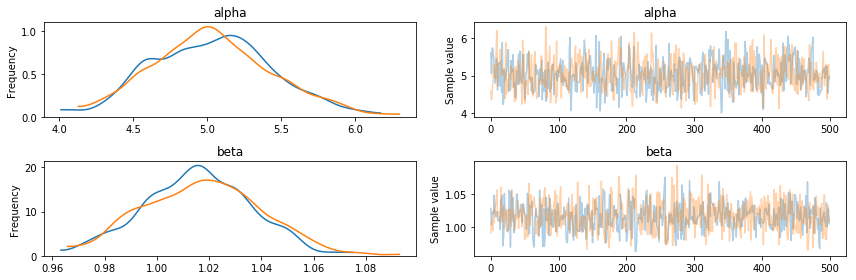

In [8]:
pm.traceplot(trace)

https://discourse.pymc.io/t/mixture-model-with-boxcox-transformation/988

In [1]:
%pylab inline
import numpy as np
import theano
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pylab as plt
import scipy as sci

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


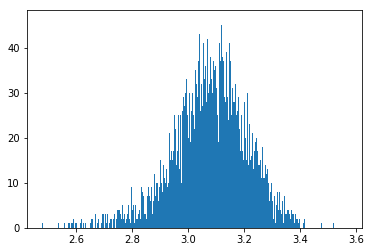

In [5]:
np.random.seed(12345)  # set random seed for reproduciblity
k = 2
ndata1 = 4500
ndata2 = 500

# simulate data from mixture distribution
data1 = np.random.normal(loc=3.1, scale=np.sqrt(0.014), size=ndata1)
data2 = np.random.normal(loc=2.9, scale=np.sqrt(0.022), size=ndata2)

plt.hist(np.concatenate((data1, data2), axis=0), 500);

In [2]:
# lambdas for the boxcox transformation
ld_1 = -0.18
ld_2 = -0.26

# Back convert the guassians to the original data scale
data1_ = sci.special.inv_boxcox(data1, ld_1)
data2_ = sci.special.inv_boxcox(data2, ld_2)

# Make the final array
combi_data = np.concatenate((data1_, data2_), axis=0)
np.random.shuffle(combi_data)

ndata = ndata1 + ndata2
plt.hist(combi_data, 1000);

In [3]:
# helper function for boxcox array stacking
def box_cox(data,  ld):
    a = sci.stats.boxcox(data, ld[0])
    b = sci.stats.boxcox(data, ld[1])
    return np.stack((a, b), axis=-1)

In [12]:
# lambda values are hard coded initially, but eventually I want to use something like Laplace
ld = np.array((-0.18, -0.26))
combi_shared = theano.shared(box_cox(combi_data, ld))
with pm.Model() as model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1.]))
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential',
                                   tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=0, sd=15, shape=2)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1] - means[0] < 0,
                                                   -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=2)

    # latent cluster of each observation
    category = pm.Categorical('category', p=p, shape=ndata)

    #BoundedLaplace= pm.Bound(pm.Laplace, lower=-1, upper=1)
    #ld = BoundedLaplace('ld',mu=0, b=0.1, shape=2)

    # likelihood for each observed value
    points = pm.Normal(
        'obs', mu=means[category], sd=sd, observed=combi_shared[category])

ValueError: Input dimension mis-match. (input[0].shape[1] = 2, input[1].shape[1] = 5000)